In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

sns.set_style("darkgrid")
sns.set_context(rc={"figure.figsize": (6, 3)})

In [4]:
dfs = {}
for name in ['train', 'test']:
    df = pd.read_csv('%s.csv' % name)
    df['_data'] = name
    dfs[name] = df

# combine train and test data into one df
df = dfs['train'].append(dfs['test'])

# lowercase column names
df.columns = map(str.lower, df.columns)

df.head()

,_data,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,train,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,train,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,train,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,train,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,train,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


In [6]:
df.shape

(17379, 13)

In [7]:
dt = pd.DatetimeIndex(df['datetime'])

df['date'] = dt.date
df['day'] = dt.day
df['month'] = dt.month
df['year'] = dt.year
df['hour'] = dt.hour
df['dow'] = dt.dayofweek
df['woy'] = dt.weekofyear
#df['weeks_since_start'] = (dt - min(dt)).days / 7

for col in ['casual', 'registered', 'count']:
    df['%s_log' % col] = np.log(df[col] + 1)

df.iloc[0]

_data                           train
atemp                          14.395
casual                              3
count                              16
datetime          2011-01-01 00:00:00
holiday                             0
humidity                           81
registered                         13
season                              1
temp                             9.84
weather                             1
windspeed                           0
workingday                          0
date                       2011-01-01
day                                 1
month                               1
year                             2011
hour                                0
dow                                 5
woy                                52
casual_log                    1.38629
registered_log                2.63906
count_log                     2.83321
Name: 0, dtype: object

In [8]:
df.head()

,_data,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,day,month,year,hour,dow,woy,casual_log,registered_log,count_log
0,train,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0,2011-01-01,1,1,2011,0,5,52,1.386294,2.639057,2.833213
1,train,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0,2011-01-01,1,1,2011,1,5,52,2.197225,3.496508,3.713572
2,train,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0,2011-01-01,1,1,2011,2,5,52,1.791759,3.332205,3.496508
3,train,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0,2011-01-01,1,1,2011,3,5,52,1.386294,2.397895,2.639057
4,train,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0,2011-01-01,1,1,2011,4,5,52,0.000000,0.693147,0.693147


In [9]:
dg = df[df['_data'] == 'train'].copy()

In [17]:
by = dg.groupby('date')['casual','registered'].agg(sum)

In [18]:
by.describe()

,casual,registered
count,456.000000,456.000000
mean,859.945175,3713.467105
std,698.913571,1494.477105
min,9.000000,491.000000
25%,318.000000,2696.000000
50%,722.000000,3700.000000
75%,1141.750000,4814.250000
max,3410.000000,6911.000000


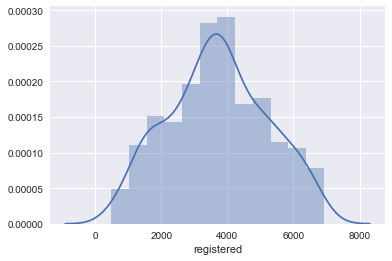

In [27]:
sns.distplot(by['registered'])

['_data',
 'atemp',
 'casual',
 'count',
 'datetime',
 'holiday',
 'humidity',
 'registered',
 'season',
 'temp',
 'weather',
 'windspeed',
 'workingday',
 'date',
 'day',
 'month',
 'year',
 'hour',
 'dow',
 'woy',
 'casual_log',
 'registered_log',
 'count_log']

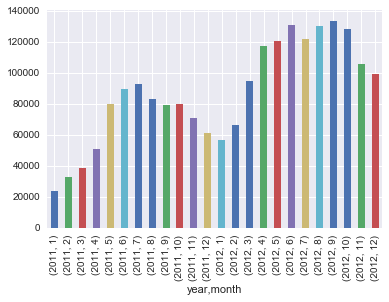

In [35]:
dg.groupby(['year', 'month'])['count'].agg(sum).plot(kind = 'bar')

list(dg)

In [33]:
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)


def get_data():
    data = df[df['_data'] == 'train'].copy()
    return data


def custom_train_test_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]
    
    return train, test


def prep_data(data, input_cols):
    X = data[input_cols].as_matrix()
    y_r = data['registered_log'].as_matrix()
    y_c = data['casual_log'].as_matrix()
    
    return X, y_r, y_c

    
def predict(input_cols, model_params={}):
    data = get_data()
    
    train, test = custom_train_test_split(data)
    
    X_train, y_train_r, y_train_c = prep_data(train, input_cols)
    X_test, y_test_r, y_test_c = prep_data(test, input_cols)

    model_params.update({
        'n_jobs': -1,
        'random_state': 123,
    })
    model = RandomForestRegressor(**model_params)
    
    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1
    
    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0
    
    y_test_comb = np.exp(y_test_r) + np.exp(y_test_c) - 2

    score = get_rmsle(y_pred_comb, y_test_comb)
    return score

In [57]:
x_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
    'holiday', 'workingday', 'season', 
    'hour', 'dow', 'year'
]

In [58]:
df_train = df[df['_data'] == 'train'].copy()
X_train = df_train[x_cols].as_matrix()
y_train_cas = df_train['casual_log'].as_matrix()
y_train_reg = df_train['registered_log'].as_matrix()

In [59]:
df_test = df[df['_data'] == 'test'].copy()
X_test = df_test[x_cols].as_matrix()


In [60]:
model = RandomForestRegressor(
    n_estimators = 1000, 
    min_samples_split = 12, 
    n_jobs = -1,
    random_state = 123456, 
)

In [61]:
casual_model = model.fit(X_train, y_train_cas)
y_pred_cas = casual_model.predict(X_test)
y_pred_cas = np.exp(y_pred_cas) - 1

In [62]:
registered_model = model.fit(X_train, y_train_reg)
y_pred_reg = registered_model.predict(X_test)
y_pred_reg = np.exp(y_pred_reg) - 1


In [63]:
df_test['count'] = np.round(y_pred_cas + y_pred_reg)


In [64]:
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('predicted.csv', index=False)
print ('boom.')

boom.


In [65]:
registered_model.feature_importances_

array([ 0.00957114,  0.02118461,  0.0117482 ,  0.0138184 ,  0.00532208,
        0.00105937,  0.05836345,  0.03873104,  0.76553556,  0.03568133,
        0.03898481])

In [66]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_cols, registered_model.feature_importances_):
    feats[feature] = importance

In [67]:
feats

{'atemp': 0.011748199316757595,
 'dow': 0.03568132798460915,
 'holiday': 0.0010593733685672309,
 'hour': 0.76553556380879373,
 'humidity': 0.013818402072303584,
 'season': 0.038731040436909572,
 'temp': 0.02118460550299198,
 'weather': 0.0095711442795096534,
 'windspeed': 0.0053220827268379151,
 'workingday': 0.05836345112550817,
 'year': 0.038984809377210702}